<h1> <i>Linear Regression Extended: Customer Lifetime Value analysis</i> </h1>

<p>This notebook provides an example code of analyzing <b>Customer lifetime value</b> using linear regression. The dependent variable we will use in OLS model is <b>Customer lifetime value</b>. We would like to understand the realtionship between CLV and other variables in the dataset and also build the model using different selection methods and data transformations. 
    
<br>The general sequence of steps for the analysis the following:
1. [Descriptive analysis](#pandas)
2.  [Modelling](#select)
4. [Running and building the OLS model /statsmodels/ (model interpretation, test performance)](#stats)
5. [Checking Linear Regression assumptions using residual analysis and statistical tests](#resid)   

<i> <u>Before starting any analysis, first import all the needed libraries.</u></i>

In [1]:
import pandas as pd #pandas for data manipulation, transformation
import matplotlib.pyplot as plt #visualization
import seaborn as sns #visualization
import numpy as np #for scientific computations
import statsmodels.api as sm #statsmodels library
from statsmodels.api import qqplot #for qq plot
from statsmodels.stats.diagnostic import het_breuschpagan,linear_rainbow  #variance equality and linearity tests
from scipy.stats import shapiro #for checking normality
from statsmodels.stats.outliers_influence import variance_inflation_factor #for checking Multicolinearity
from sklearn.model_selection import train_test_split #for train and test split
from sklearn.metrics import r2_score #R-squared

 <h2>1.Descriptive analysis</h2> <a name="pandas"></a>

In [2]:
#importing the data and making a dataframe
url="https://raw.githubusercontent.com/srbuhimirzoyan/Business_Analytics_Spring2020/master/Session_5_CLV_data.xlsx"
data=pd.read_excel(url)

In [3]:
#data overview
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
Customer                         9134 non-null object
State                            9134 non-null object
Customer_Lifetime_Value          9134 non-null float64
Response                         9134 non-null object
Coverage                         9134 non-null object
Education                        9134 non-null object
Effective_To_Date                9134 non-null datetime64[ns]
EmploymentStatus                 9134 non-null object
Gender                           9134 non-null object
Income                           9134 non-null int64
Location_Code                    9134 non-null object
Marital_Status                   9134 non-null object
Monthly_Premium_Auto             9134 non-null int64
Months_Since_Last_Claim          9134 non-null int64
Months_Since_Policy_Inception    9134 non-null int64
Number_of_Open_Complaints        9134 non-null int64
Number_of_Policies       

We have 24 variables of 9134 observations.

In [4]:
#have a look at first rows of the dataframe
data.head()

,Customer,State,Customer_Lifetime_Value,Response,Coverage,Education,Effective_To_Date,EmploymentStatus,Gender,Income,...,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies,Policy_Type,Policy,Renew_Offer_Type,Sales_Channel,Total_Claim_Amount,Vehicle_Class,Vehicle_Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2011-02-24,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,2011-01-31,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2011-02-19,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,2011-01-20,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2011-02-03,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [5]:
data.describe()

,Customer_Lifetime_Value,Income,Monthly_Premium_Auto,Months_Since_Last_Claim,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies,Total_Claim_Amount
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794
std,6870.967608,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007
25%,3994.251794,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244
50%,5780.182197,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434
75%,8962.167041,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839
max,83325.381190,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678


In [6]:
#checking number of duplicates, missing values and columns with a single value
print("Duplicates:", data.duplicated().sum())
print("Missing values:", data.isna().sum().sum())
print("Single valued columns:", data.columns[data.nunique()==1])

Duplicates: 0
Missing values: 0
Single valued columns: Index([], dtype='object')


Note that in case of having duplicated values we will drop them using <code>drop_duplicates()</code> method

In [7]:
# Let's drop some columns:
# Customer (as this is juat an ID and should not affect CLV)
# Effective_To_Date (as this is date and to include we should extract month or year or else from it)
drops = ["Customer","Effective_To_Date"]
data = data.drop(drops,axis=1)

 <h3>2.1.Descriptive analysis using visualization</h3>

<i><b>Let's outline some questions that might be insightful from CLV analytics point.</i></b>

      -Relationship between CLV and Income.
      -Is CLV different by Gender,Marital Status? 
      -Income by Vehicle class/size (perform yourself)

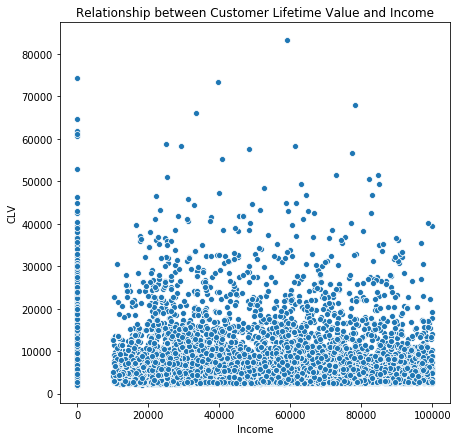

In [8]:
#Let's plot scatterplot of CLV and Income
plt.figure(figsize=(7,7))
sns.scatterplot(data.Income,data.Customer_Lifetime_Value,)
plt.xlabel("Income")
plt.ylabel("CLV")
plt.title("Relationship between Customer Lifetime Value and Income")
plt.show()

In [9]:
#We can see a lot of customers having 0 income.
#As wee see, all of them are unemployed
data["EmploymentStatus"][data.Income==0].value_counts()

Unemployed    2317
Name: EmploymentStatus, dtype: int64

In [10]:
#As we have pretty much 0s in the data, to avoid errors, we will use np.log1p
print("\n","Natural log:",np.log(0),"\n","Natural log +1:",np.log(0+1),"\n","Np.log1p:",np.log1p(0))


 Natural log: -inf 
 Natural log +1: 0.0 
 Np.log1p: 0.0


C:\Users\Srbuhi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


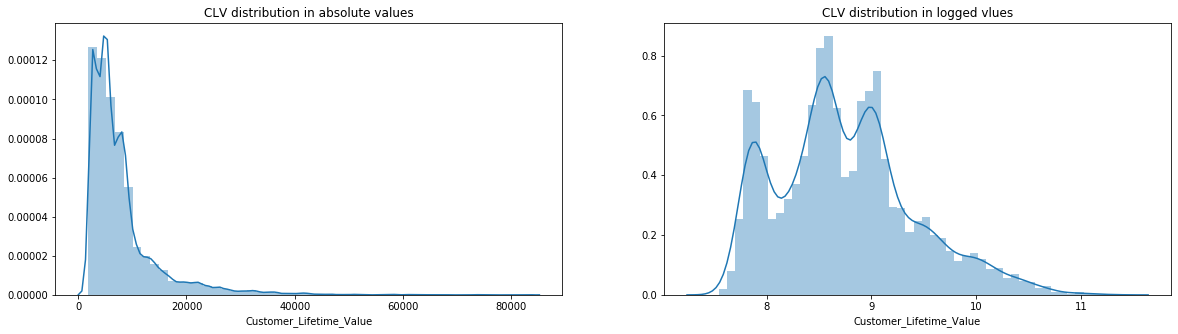

In [11]:
#let's visualise the distribution of CLV vs log(CLV)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.distplot(data.Customer_Lifetime_Value)
plt.title("CLV distribution in absolute values")

plt.subplot(1,2,2)
sns.distplot(np.log1p(data.Customer_Lifetime_Value))
plt.title("CLV distribution in logged vlues")

plt.show()

As it can be seen, we have a right-skewed data  of a large scale and the log(Price) distribution changed the situation to better one.

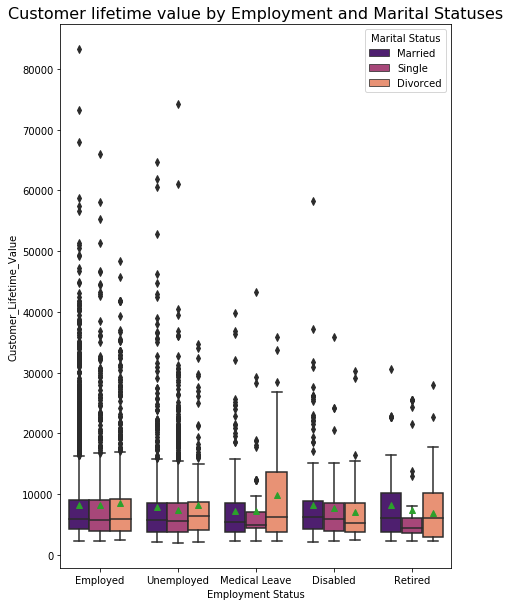

In [12]:
plt.figure(figsize=(7,10))
sns.boxplot(x="EmploymentStatus",y="Customer_Lifetime_Value", data=data, palette='magma',hue=data.Marital_Status,  showmeans=True)
plt.legend(title='Marital Status', loc='upper right')
plt.xlabel("Employment Status")
plt.title("Customer lifetime value by Employment and Marital Statuses",fontdict={"fontsize":16})
plt.show()

As we see, there is no interaction term of marital and employment statuses on CLV, mean values are almost the same.

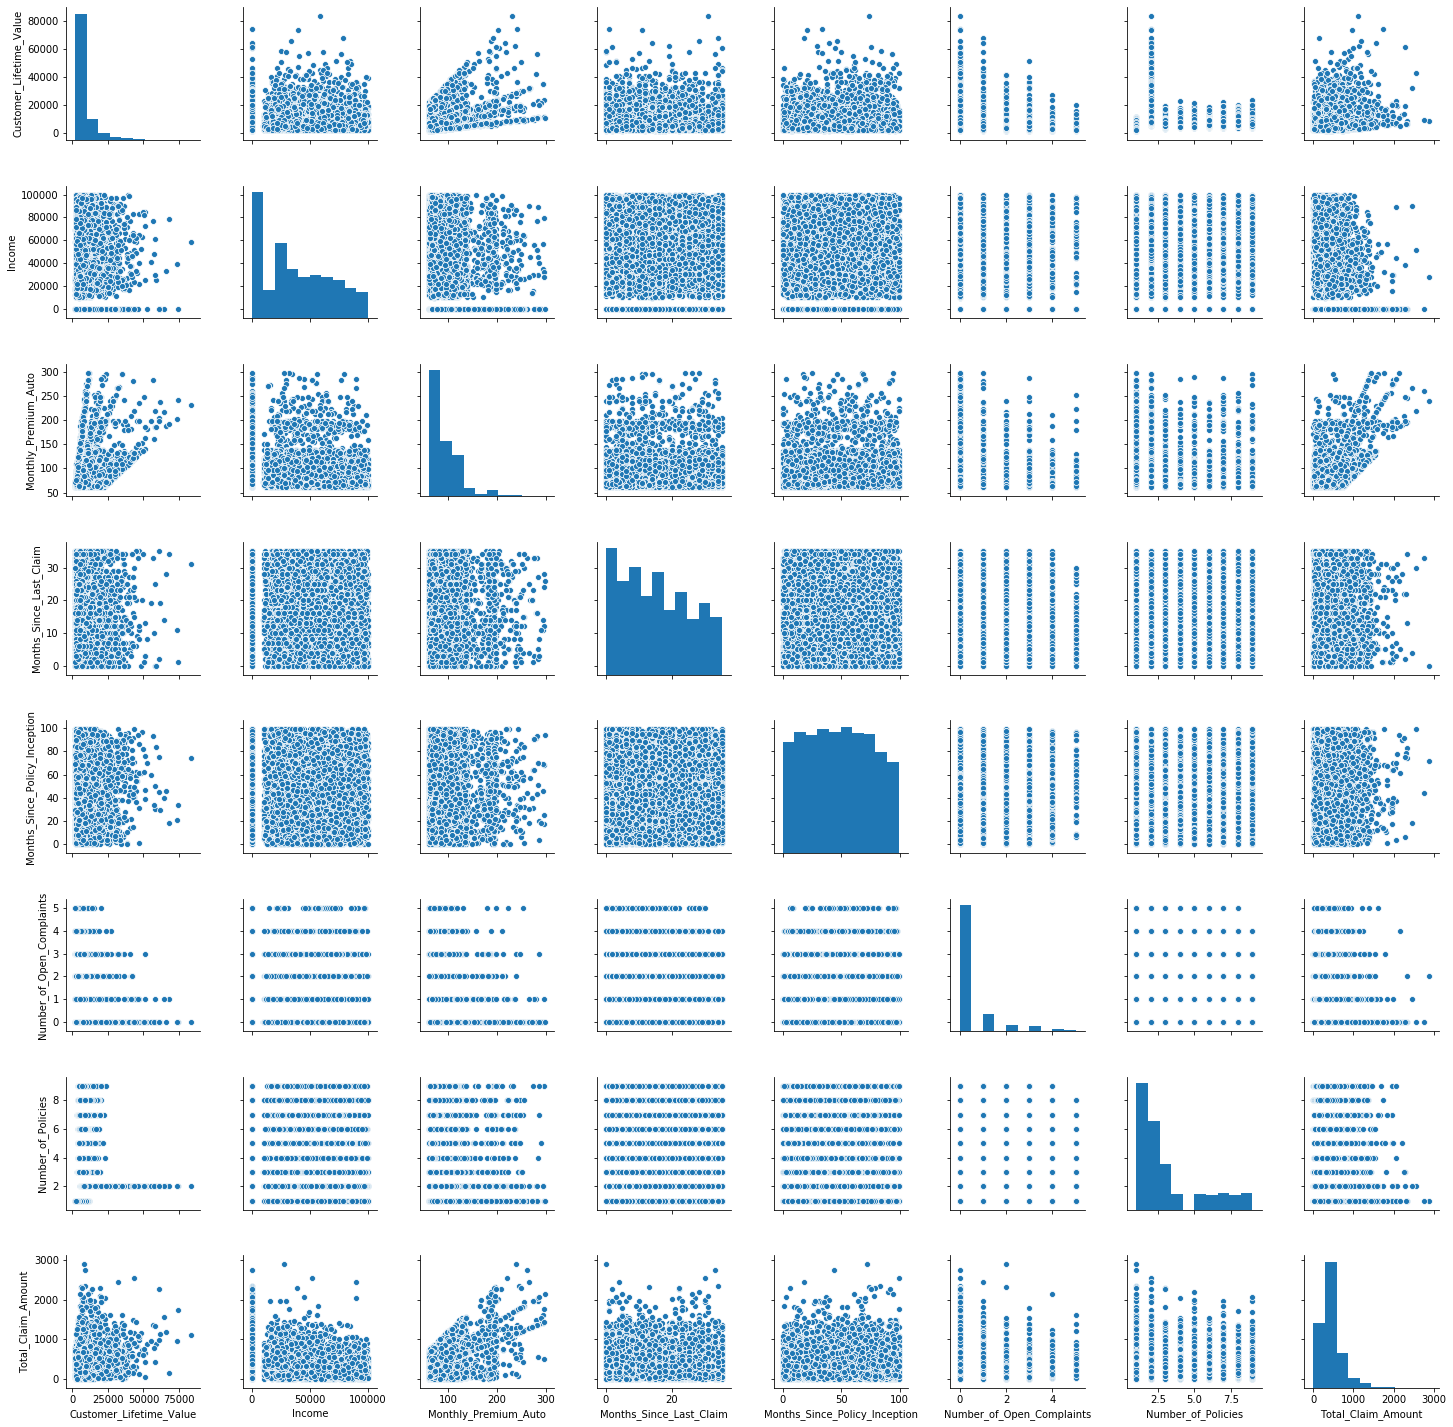

In [13]:
#To see the visual representation of pairwise relationships in a dataset, a pairplot is used. Note that it only plots numeric
#columns.
sns.pairplot(data)

We can clearly see a positive relationship between CLV and Monthly_premium_auto.It is also notable that the value of 2 for "Number_of_Policies" is significantly different from others.

 <h3><u>Checking for correlations (multicollinearity)</u></h3>

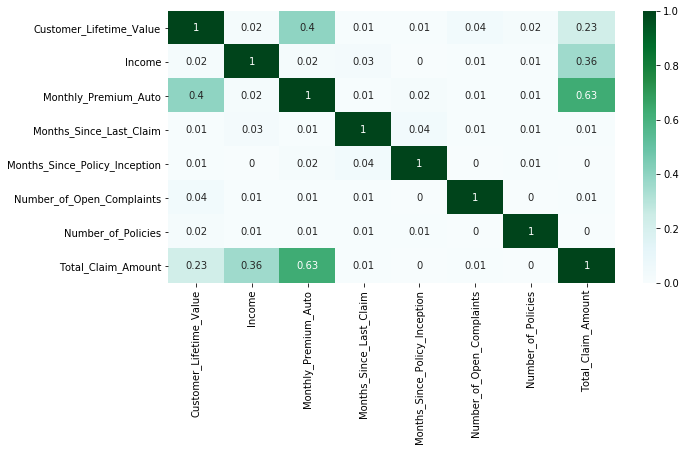

In [14]:
#Let's visualize correlations
plt.figure(figsize=(10,5))
sns.heatmap(data.corr().abs().round(2),annot=True, cmap = "BuGn")
plt.show()

The correlation matrix shows that "Number_of_Policies","Total_Claim_Amount","Monthly_Premium_Auto", "Number_of_Open_Complaints", "Income" have the highest correlation with CLV. 

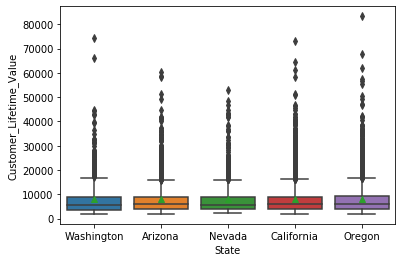

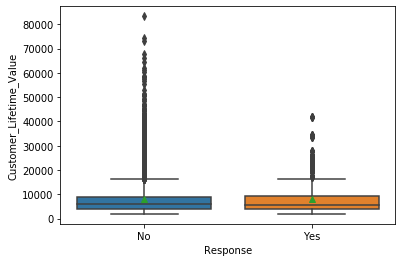

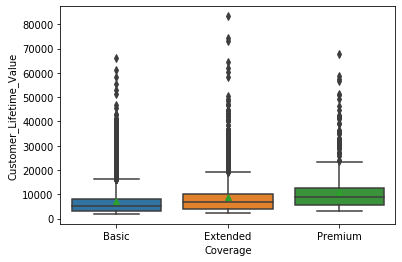

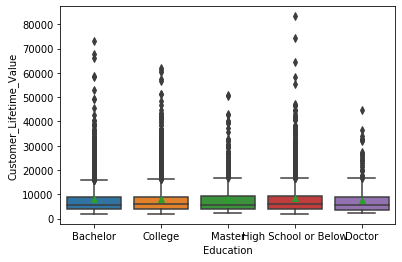

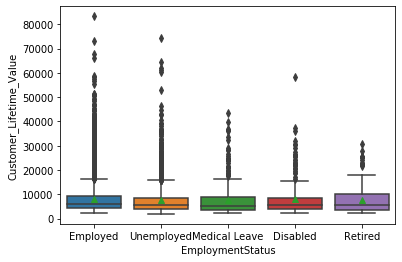

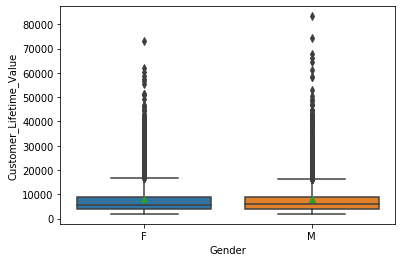

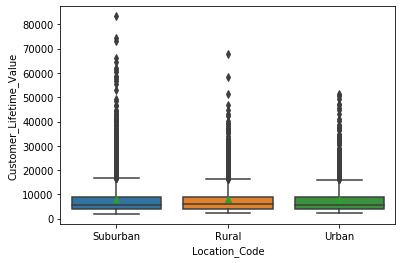

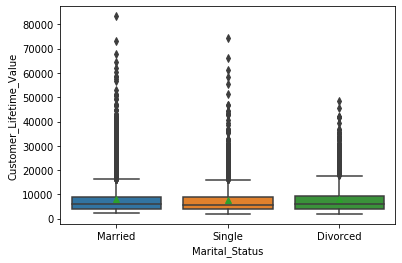

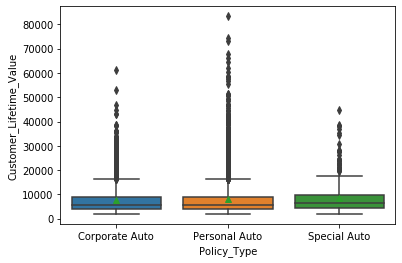

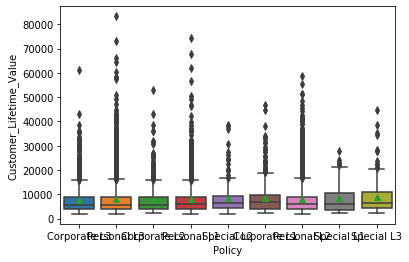

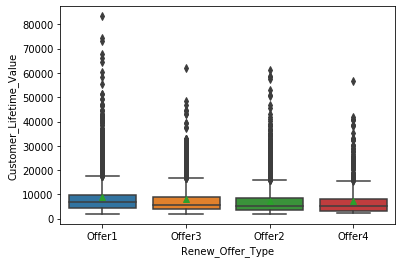

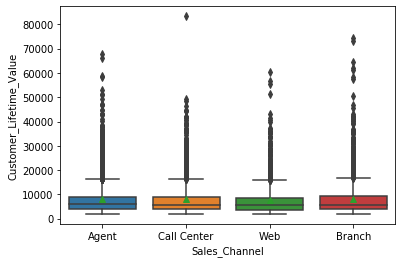

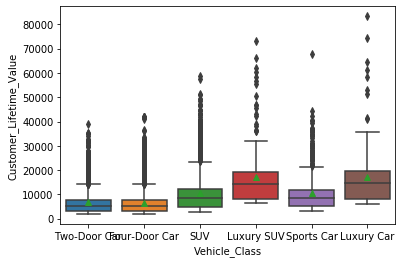

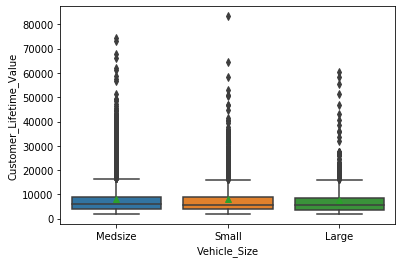

In [15]:
#Let's also see whether mean CLV differs by any of the categorical variables.
#to see that, let's visualize CLV by each categorical variable represented in boxplot.
categoricals=data.dtypes[data.dtypes=="O"].index.tolist()
for i in categoricals:
    sns.boxplot(data=data,x=i,y="Customer_Lifetime_Value", showmeans=True)
    plt.show()

As it can be seen, visually CLV is significantly different for only some levels of several categorical variables, specifically:
"Premium" of Coverage,"Employed" of EmploymentStatus,"Luxury SUV" of Vehicle Class.
Thus let's build a model for the noted covariates and the ones having highest correlation with CLV and disregard all the other levels of categorical variables, based on visual evidence and in order to avoid a lot of columns with not significant p-values.

<h1> 2. Modelling </h1> <a name="select"> </a>

 The steps will be as following:
    1. split the data into train and test sets,
    2. build(fit) the model on the train set and see the summary (look at F-statistics, R-squared),
    3. make predictions for the test set and calculate the R-squared,
    4. compare train-test score gap, analyse train model coefficients p-values and make the transformations,
    5. repeat until a desired score is got,
    6. in case of having several competing models (from test score similarity point), check assumptions for all models and    select the one holding all of them. If LINE is not held, transform the data further.
    7. NOTE: Coefficients are interpreted for the models fitted on training set.

In [16]:
#separating X and Y
Y = data.Customer_Lifetime_Value
X = data.drop(["Customer_Lifetime_Value"],axis=1)

In [18]:
#let's outline only several variables as discussed above and build model on them
selected_covariates = ["Number_of_Policies","Total_Claim_Amount", "Number_of_Open_Complaints","EmploymentStatus","Coverage","Vehicle_Class"]

In [19]:
#log-transforming Customer Lifetime Value
Y = np.log1p(Y)
X = X[selected_covariates]
X.head()

,Number_of_Policies,Total_Claim_Amount,Number_of_Open_Complaints,EmploymentStatus,Coverage,Vehicle_Class
0,1,384.811147,0,Employed,Basic,Two-Door Car
1,8,1131.464935,0,Unemployed,Extended,Four-Door Car
2,2,566.472247,0,Employed,Premium,Two-Door Car
3,7,529.881344,0,Unemployed,Basic,SUV
4,1,138.130879,0,Employed,Basic,Four-Door Car


In [20]:
#transforming the selected covariates
X["Number_of_Policies_1"] = np.where(X.Number_of_Policies==1,1,0) #making a dummy variable when # of policies=1
X["Number_of_Policies"] = np.where(X.Number_of_Policies==2,1,0) #making a dummy variable when # of policies=2
X["EmploymentStatus"] = np.where(X.EmploymentStatus=="Employed",1,0) #outlining Employed customers
X["Coverage"] = np.where(X.Coverage=="Premium",1,0) #outlining Premium coverage

In [21]:
#getting dummies
X = pd.get_dummies(X,drop_first=True)

In [22]:
#adding constraint to X
X=sm.add_constant(X)

C:\Users\Srbuhi\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [23]:
#having an overview of X
X.head()

,const,Number_of_Policies,Total_Claim_Amount,Number_of_Open_Complaints,EmploymentStatus,Coverage,Number_of_Policies_1,Vehicle_Class_Luxury Car,Vehicle_Class_Luxury SUV,Vehicle_Class_SUV,Vehicle_Class_Sports Car,Vehicle_Class_Two-Door Car
0,1.0,0,384.811147,0,1,0,1,0,0,0,0,1
1,1.0,0,1131.464935,0,0,0,0,0,0,0,0,0
2,1.0,1,566.472247,0,1,1,0,0,0,0,0,1
3,1.0,0,529.881344,0,0,0,0,0,0,1,0,0
4,1.0,0,138.130879,0,1,0,1,0,0,0,0,0


<h1> 4. Running and building the OLS model /statsmodels/ (interpretation,test performance) </h1> <a name="stats">

In [24]:
#splitting the data into train and test sets
X0, X1, Y0, Y1 = train_test_split(X, Y, test_size=0.25, random_state=42)

In [25]:
#observing the results
results=sm.OLS(Y0, X0).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Customer_Lifetime_Value   R-squared:                       0.868
Model:                                 OLS   Adj. R-squared:                  0.868
Method:                      Least Squares   F-statistic:                     4084.
Date:                     Sat, 04 Apr 2020   Prob (F-statistic):               0.00
Time:                             13:04:28   Log-Likelihood:                 174.94
No. Observations:                     6850   AIC:                            -325.9
Df Residuals:                         6838   BIC:                            -243.9
Df Model:                               11                                         
Covariance Type:                 nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          8.5331      0.009    936.467      0.000       8.515       8.551
Number_of_Policies             0.7010      0.007     96.458      0.000       0.687       0.715
Total_Claim_Amount             0.0001   1.36e-05      7.999      0.000     8.2e-05       0.000
Number_of_Open_Complaints     -0.0244      0.003     -7.820      0.000      -0.031      -0.018
EmploymentStatus               0.1139      0.007     17.502      0.000       0.101       0.127
Coverage                       0.3402      0.010     32.828      0.000       0.320       0.360
Number_of_Policies_1          -0.6900      0.007   -104.312      0.000      -0.703      -0.677
Vehicle_Class_Luxury Car       0.8941      0.023     38.343      0.000       0.848       0.940
Vehicle_Class_Luxury SUV       0.9270      0.023     40.934      0.000       0.883       0.971
Vehicle_Class_SUV              0.4259      0.008     52.377      0.000       0.410       0.442
Vehicle_Class_Sports Car       0.4642      0.013     35.066      0.000       0.438       0.490
Vehicle_Class_Two-Door Car  1.765e-05      0.007      0.002      0.998      -0.015       0.015
==============================================================================
Omnibus:                     1418.714   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3553.731
Skew:                           1.135   Prob(JB):                         0.00
Kurtosis:                       5.701   Cond. No.                     4.82e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Interpretation of the results of Linear Regression for log(CLV)
##### Note: As we have log-linear model, to interpret the effect of significant independent variable on CLV you should multiply coefficient estimate with 100 and interpret the result in %. I.e. for Total_Claim_Amount it will be the following: 1 unit change in Total_Claim_Amount leads to 100*0.0001=0.01‬%  percent change in CLV.


- <b>R-squared and F-statistics</b>: As Prob (F-statistic) shows our model is statistically significant at 5% significance level, so there is at least one estimated coefficient (besides intercept) that is not null. R-squared is quite big number and it shows that 86.8% of variance in log(CLV) is explained by the variables included in the model.
- <b>Adj. R-squared</b>: As summary shows it's the same as R-squared, 86.8% which means that we have a very consistent model.
- <b>Statistically significant variables</b>: As p-values of t-statistics show, all variables included in the model are statistically significant at 5% sig. level (p<=0.05).
- <b>Coefficients (continous variable)</b>: Let's interpret for Total_Claim_Amount. For each unit increase in Total_Claim_Amount we will experience on average about 0.0001 dollars increase in mean log(CLV).
- <b>Coefficients (categorical variable)</b>:Let's interpret for Vehicle_Class, Luxury SUV subclass. If a car has "Luxury SUV" class rather than "Four-Door Car" then on average 0.9270 dollars increase is expected in mean log(CLV).

In [26]:
#predicting for train and test data
Y1_linear=results.predict(sm.add_constant(X1))
Y0_linear=results.predict(X0)

In [27]:
#let's see r-squared for train and test sets for the initial model
print("R-squared Train:",r2_score(Y0,Y0_linear))
print("R-squared Test:",r2_score(Y1,Y1_linear))

R-squared Train: 0.8678844801123413
R-squared Test: 0.8685771304763494


We can see that it is possible to get a good, constant model based on visual observations of variables and some minor transformations. 
Let's also check the internal validity of the model

<h1>5.Checking Linear Regression assumptions using residual analysis (visual evidence)</h1><a name="resid"></a>

To check the assumptions using residual analysis we will plot the fitted values vs error terms (residuals). It should not exhibit any patterns (should be randomly distributed) to meet the Linearity, Normality and Independence assumptions.

In [28]:
#residuals of the model
residuals=results.resid
predicted_values=results.predict()

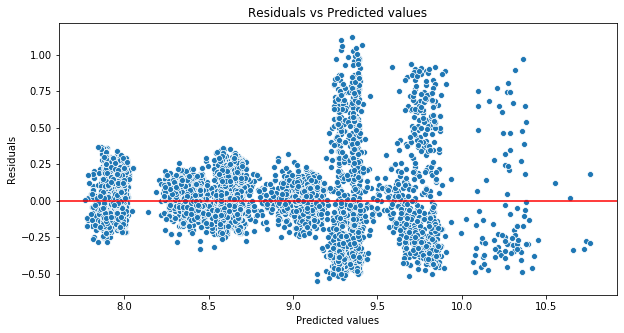

In [29]:
#lets plot predicted values vs residuals
plt.figure(figsize=(10,5))
sns.scatterplot(predicted_values,residuals)
plt.axhline(y=0, c="red")
plt.title("Residuals vs Predicted values")
plt.ylabel("Residuals")
plt.xlabel("Predicted values")
plt.show()

The residuals vs fitted values plot pattern is not totally random and we can see groups of observations scattered together
around some points. We also observe a very high variance from the left to the right.

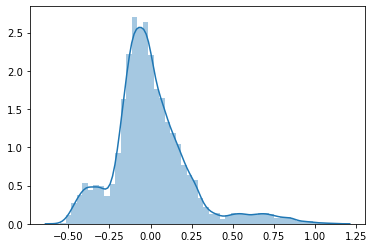

In [30]:
#Normality
#visual presentation- histogram
sns.distplot(residuals)
plt.show()

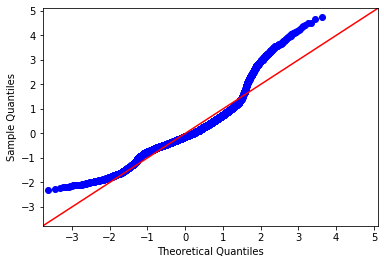

In [31]:
#QQ plot
qqplot(residuals,fit=True, line='45')
plt.show()

The residuals distribution plot shows that the distribution is not normal.
QQ-plot shows a nonlinear pattern too.

<h2>Diagnostic tests for Linear Regression assumptions </h2>

In [32]:
#Linearity 
#The null hypothesis assumes that the regression is correctly modelled as linear
rnames=["fstat", "p-value"]
rainbow=linear_rainbow(results)
print(list(zip(rnames, rainbow)))

[('fstat', 1.0355340030042557), ('p-value', 0.15369555295656667)]


Linearity assumption is held at 5% significance level (p-value=0.15>0.05).

In [33]:
#Breusch-Pagan test for homoscedasticity
#The null hypothesis assumes homoskedasticity
bnames = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
breush = het_breuschpagan(residuals, results.model.exog)
print(list(zip(bnames, breush)))


[('Lagrange multiplier statistic', 2250.657847953078), ('p-value', 0.0), ('f-value', 304.19366816807366), ('f p-value', 0.0)]


We reject the null hypothesis based on 5% significance level, thus homoscedasticity assumption is not held.

In [34]:
#Shapiro-Wilk normality test. 
#The null-hypothesis of this test is that the data was drawn from a normal distribution
snames=['The test statistic', 'p-value']
shapiro=shapiro(residuals)
print(list(zip(snames, shapiro)))

[('The test statistic', 0.9232485890388489), ('p-value', 0.0)]


C:\Users\Srbuhi\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Test confirms that the data was not drawn from a normal distribution.

In [35]:
#defining colnames 
var=X.columns.tolist()

In [36]:
#Multicollinearity
#calculating vif using variance_inflation_factor() function from statsmodel
vif = [variance_inflation_factor(X[var].values, i) for i in range(0,len(var))]
print(vif)

[10.175796997538542, 1.2287663729197085, 1.914462011285641, 1.0011289898280673, 1.2167941864553364, 1.0990248423199038, 1.228577460242294, 1.2580524624567295, 1.258959759440782, 1.281230612125221, 1.091404507232659, 1.1179072631500433]


In [37]:
#printing vif values together with variable names
for i in range(0,len(var)):
    print(var[i],":",vif[i])

const : 10.175796997538542
Number_of_Policies : 1.2287663729197085
Total_Claim_Amount : 1.914462011285641
Number_of_Open_Complaints : 1.0011289898280673
EmploymentStatus : 1.2167941864553364
Coverage : 1.0990248423199038
Number_of_Policies_1 : 1.228577460242294
Vehicle_Class_Luxury Car : 1.2580524624567295
Vehicle_Class_Luxury SUV : 1.258959759440782
Vehicle_Class_SUV : 1.281230612125221
Vehicle_Class_Sports Car : 1.091404507232659
Vehicle_Class_Two-Door Car : 1.1179072631500433


As we see there is no multicollinearity issue for this model.